In [1]:
import itertools
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from utils import FundamentalData, delta, rank, alpha_example_1, alpha_example_2


In [2]:
class FinancialDataProcessor:
    def __init__(self, dates_file, stocks_file, data_file, alpha_function, alpha_function_2):
        self.fundamental_data = FundamentalData(dates_file, stocks_file, data_file)
        self.alpha_function = alpha_function
        self.alpha_function_2 = alpha_function_2
        self.dates = self.fundamental_data.date_df
        self.stocks = self.fundamental_data.stocks_df
        self.data = self.fundamental_data.data.to_dataframe()
        self.weight_matrix = np.zeros((len(self.dates), len(self.stocks)))
        self.normalized_weight_matrix = None
        self.pnl_matrix = np.zeros((len(self.dates), len(self.stocks)))

    def calculate_weights(self):
        alpha_values = self.alpha_function(self.fundamental_data)
        # print(alpha_values)
        # self.alpha_function_2(self.fundamental_data)
        for i, j in itertools.product(range(len(self.dates)), range(len(self.stocks))):
            self.weight_matrix[i, j] = alpha_values.loc[self.dates['date'][i], self.stocks['Symbol'][j]]

        weights = self.weight_matrix.flatten()
        normalized_weights = weights - np.mean(weights)
        total_abs_sum = np.sum(np.abs(normalized_weights))
        adjustment_factor = 250 / total_abs_sum
        adjusted_weights = normalized_weights * adjustment_factor
        self.normalized_weight_matrix = adjusted_weights.reshape(self.weight_matrix.shape)
        # print(self.normalized_weight_matrix)

    def calculate_pnl(self):
        for i, j in itertools.product(range(len(self.dates)), range(len(self.stocks))):
            self.pnl_matrix[i, j] = (self.data.at[(self.dates['date'][i], self.stocks['Symbol'][j]), 'close'] - 
                                     self.data.at[(self.dates['date'][i], self.stocks['Symbol'][j]), 'open'])
            self.pnl_matrix[i, j] *= self.normalized_weight_matrix[i, j]

    def plot_daily_pnl(self):
        pnl_df = pd.DataFrame(self.pnl_matrix, index=self.dates['date'], columns=self.stocks['Symbol'])
        daily_pnl = pnl_df.sum(axis=1)
        daily_pnl.plot()
        plt.xlabel('Date')
        plt.ylabel('PnL')
        plt.show()

/var/folders/22/4w96t86s5f3_vj4kp3hnq_ph0000gn/T/ipykernel_85915/4052789152.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.weight_matrix[i, j] = alpha_values.loc[self.dates['date'][i], self.stocks['Symbol'][j]]


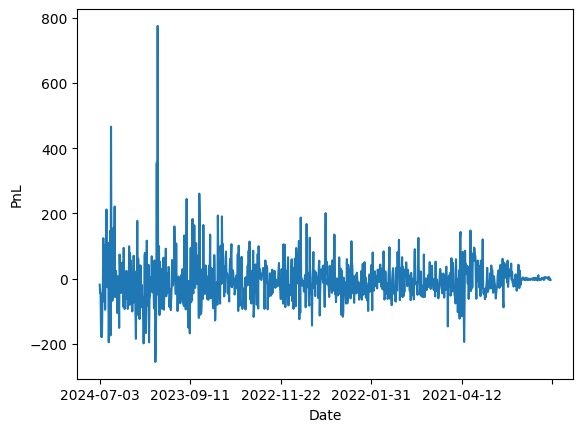

In [3]:
processor = FinancialDataProcessor('date.csv', 'ind_nifty500list.csv', 'my_3d_dataarray.nc', alpha_example_1, alpha_example_2)
processor.calculate_weights()
processor.calculate_pnl()
processor.plot_daily_pnl()